# Causal Explanations with LEWIS
This notebook implements **LEWIS**, a causal explanation framework for black-box machine learning models. Using probabilistic contrastive counterfactuals, we compute **Necessity (Nec)**, **Sufficiency (Suf)**, and **Necessity-and-Sufficiency (NeSuf)** scores to quantify causal feature importance without relying on model internals. This notebook follows the methodology proposed by Galhotra et al. (SIGMOD 2021).

**Reference:**
* Sainyam Galhotra, Romila Pradhan, Babak Salimi (2021). Explaining Black-Box Algorithms Using Probabilistic Contrastive Counterfactuals. SIGMOD '21: International Conference on Management of Data, Virtual Event, China, June 20-25, 2021.

In [1]:
import numpy as np
import pandas as pd
import operator
import graphviz
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import lingam
from lingam.utils import make_dot

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.26.4', '2.3.0', '0.20.3', '1.12.1']


## Test data
We create test data consisting of 7 variables.

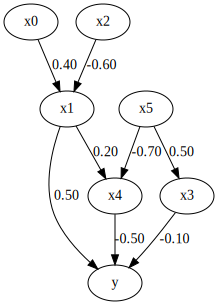

,x0,x1,x2,x3,x4,x5,y
0,0.119568,-0.182500,0.763061,-0.373908,-0.315997,-0.326320,-0.202553
1,0.527104,-0.954103,-0.058582,0.069640,0.319117,-0.495717,-0.818257
2,0.251718,0.007441,0.056720,0.154034,-0.146964,-1.056711,0.510195
3,0.109941,0.922016,-0.611097,0.680521,0.069137,-0.361232,0.605658
4,-0.187007,-1.346211,0.257302,0.447058,-0.904446,-0.655983,-1.317686


In [2]:
m = np.array([
    [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [ 0.4, 0.0,-0.6, 0.0, 0.0, 0.0, 0.0],
    [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0],
    [ 0.0, 0.2, 0.0, 0.0, 0.0,-0.7, 0.0],
    [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [ 0.0, 0.5, 0.0,-0.1,-0.5, 0.0, 0.0],
])

generate_error = lambda p: np.random.uniform(-p, p, size=1000)

error_vars = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
params = [0.5 * np.sqrt(12 * v) for v in error_vars]
e = np.array([generate_error(p) for p in params])

cols = [f"x{i}" for i in range(len(m) - 1)] + ["y"]
X = np.linalg.pinv(np.eye(len(m)) - m) @ e
df = pd.DataFrame(X.T, columns=cols)

display(make_dot(m, labels=cols))
df.head()

## Discretization
LEWIS assumes that all features have finite, discrete domains. Therefore, continuous-valued features must be discretized before computing LEWIS scores. Each continuous feature is binned into a small number of ordered categories (e.g., Low < Medium < High), enabling contrastive value pairs $(x, x′)$ and well-defined computation of Necessity, Sufficiency, and Necessity-and-Sufficiency scores.

In [3]:
kbd = KBinsDiscretizer(n_bins=2, encode="ordinal", strategy="uniform", subsample=None)
df["y"] = kbd.fit_transform(df["y"].values.reshape(-1, 1))

feature_names = [f"x{i}" for i in range(len(m) - 1)]
for name in feature_names:
    kbd = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform", subsample=None)
    df[name] = kbd.fit_transform(df[name].values.reshape(-1, 1))

df.head()

,x0,x1,x2,x3,x4,x5,y
0,2.0,2.0,4.0,1.0,2.0,1.0,0.0
1,3.0,1.0,2.0,2.0,2.0,1.0,0.0
2,3.0,2.0,2.0,2.0,2.0,0.0,1.0
3,2.0,3.0,1.0,3.0,2.0,1.0,1.0
4,2.0,1.0,3.0,3.0,1.0,1.0,0.0


## Model Training and Prediction with RandomForestClassifier
We train a black-box prediction model using a RandomForestClassifier. The model learns a non-linear decision function by aggregating predictions from multiple decision trees trained on bootstrapped samples of the data. After training, the model is used to generate predictions (and class probabilities) for each instance. These predicted outcomes serve as the decision variable used in subsequent LEWIS analysis, while the internal structure of the model remains opaque.

In [4]:
X = df[feature_names]
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
X_test["y"] = y_pred
X_test.head()

,x0,x1,x2,x3,x4,x5,y
993,2.0,2.0,4.0,2.0,1.0,2.0,0.0
859,1.0,0.0,4.0,3.0,2.0,1.0,0.0
298,4.0,3.0,4.0,1.0,4.0,1.0,0.0
553,2.0,1.0,4.0,2.0,0.0,4.0,0.0
672,3.0,2.0,2.0,1.0,1.0,2.0,1.0


## Computing LEWIS Scores
We compute LEWIS explanation scores—**Necessity (Nec)**, **Sufficiency (Suf)**, and **Necessity-and-Sufficiency (NeSuf)**—for each selected feature using a causal, model-agnostic approach. Based on the given causal graph, we first identify an adjustment set that satisfies the **backdoor criterion** for the relationship between the target feature and the outcome. These variables are used only for probability estimation and are not part of the user-facing explanation.

For an ordinal feature with ordered values $(x^{(1)} \prec \dots \prec x^{(L)})$, we compute Nec, Suf, and NeSuf for **all ordered value pairs** $(x, x')$ such that $(x \succ x')$. After evaluating all pairs, we select the pair that **maximizes NeSuf** as the most causally responsive contrast. The corresponding Nec and Suf values for this same pair are then reported, ensuring that all three scores are aligned to a single, interpretable intervention.

In [5]:
backdoor = {
    'x0': [],
    'x1': [],
    'x2': [],
    'x3': ['x5'],
    'x4': ['x1', 'x5'],
    'x5': [],
}

In [6]:
def max_nesuf(score_dic, score, name):
    pre_score = [0, 0, 0]
    if name in score_dic.keys():
        pre_score = score_dic[name]
    if score[2] > pre_score[2]: # nesuf
        score_dic[name] = score
    return score_dic

In [7]:
score_dic = {}
for name in feature_names:
    val = {}
    for v in df[name].unique():
        df_temp = df[df[name] == v]
        vc = df_temp["y"].value_counts().reindex([0, 1], fill_value=0)
        val[v] = vc[1] * 1.0 / (vc[0] + vc[1])
    sorted_val = sorted(val.items(), key=operator.itemgetter(1))

    for i, (before, _) in enumerate(sorted_val):
        for after, _ in sorted_val[i + 1 :]:
            lewis = lingam.LEWIS()
            score = lewis.get_scores(
                X_test,
                x_names=[name],
                x_values=[after],
                x_prime_values=[before],
                o_name="y", 
                c_names=backdoor[name])
            score_dic = max_nesuf(score_dic, score, name)
            print(f"{name}: {before}->{after}: score={score}")


x0: 0.0->1.0: score=(0.28876449588651437, 0.15671962820931234, 0.11307290998254543)
x0: 0.0->2.0: score=(0.37054073719681124, 0.22722774483181898, 0.16394438035923292)
x0: 0.0->3.0: score=(0.308951540247843, 0.1725738099335212, 0.12451167156864434)
x0: 0.0->4.0: score=(0.3041121895598342, 0.16868933442058193, 0.12170902996578553)
x0: 1.0->2.0: score=(0.11497772655799332, 0.08361171323457248, 0.05087147037668749)
x0: 1.0->3.0: score=(0.028383066149784867, 0.018800605652118815, 0.011438761586098911)
x0: 1.0->4.0: score=(0.02157891947822522, 0.014194218923715932, 0.008636119983240098)
x0: 2.0->3.0: score=(0.0, 0.0, 0.0)
x0: 2.0->4.0: score=(0.0, 0.0, 0.0)
x0: 3.0->4.0: score=(0.0, 0.0, 0.0)
x1: 0.0->1.0: score=(1.0, 0.058517831098751374, 0.058517831098751374)
x1: 0.0->2.0: score=(1.0, 0.3863071221311797, 0.3863071221311797)
x1: 0.0->3.0: score=(1.0, 0.6916588068976024, 0.6916588068976024)
x1: 0.0->4.0: score=(1.0, 0.610516293905489, 0.610516293905489)
x1: 1.0->2.0: score=(0.84851992690189

## Visualization of LEWIS Scores Sorted by NeSuf
Finally, we visualize the LEWIS scores using a horizontal bar chart, where features are **sorted in descending order of NeSuf**. NeSuf represents the strongest indicator of causal importance, capturing how often a feature change would flip the decision outcome in both directions. By sorting features by NeSuf, the plot highlights which features are most causally influential overall. For each feature, the corresponding **Nec and Suf values for the same maximizing contrast** are displayed alongside NeSuf, enabling a consistent and interpretable comparison.

In [8]:
def plot_scores_barh_featurecol(
    df,
    feature_col="feature",
    value_cols=("Nec", "Suf", "NeSuf"),
    title="LEWIS Scores",
    reverse_for_image=True,
):
    needed = [feature_col, *value_cols]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"df is missing columns {missing}. Required columns: {needed}")

    df_plot = (
        df.loc[:, needed]
        .dropna(subset=[feature_col])
        .drop_duplicates(subset=[feature_col])
        .set_index(feature_col)
        .loc[:, list(value_cols)]
    )

    if reverse_for_image:
        df_plot = df_plot.iloc[::-1]

    y = np.arange(len(df_plot.index))
    h = 0.22 

    fig, ax = plt.subplots(figsize=(3.0, 3.6), dpi=120)

    bars1 = ax.barh(
        y + h,
        df_plot[value_cols[0]].values,
        height=h,
        color="#4C72B0",
        edgecolor="black",
        linewidth=0.6,
        label=value_cols[0],
    )
    bars2 = ax.barh(
        y,
        df_plot[value_cols[1]].values,
        height=h,
        color="#F0E442",
        edgecolor="black",
        linewidth=0.6,
        label=value_cols[1],
    )
    bars3 = ax.barh(
        y - h,
        df_plot[value_cols[2]].values,
        height=h,
        color="#2CA02C",
        edgecolor="black",
        linewidth=0.6,
        label=value_cols[2],
    )

    ax.set_yticks(y)
    ax.set_yticklabels(df_plot.index)
    ax.set_xlim(0, 1.0)
    ax.set_xticks([0.0, 0.5, 1.0])
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.set_xlabel(title)
    ax.legend(loc="lower right", fontsize=7, frameon=True)

    def add_labels(bars):
        for b in bars:
            w = b.get_width()
            yy = b.get_y() + b.get_height() / 2
            ax.text(w + 0.01, yy, f"{w:.2f}", va="center", ha="left", fontsize=7)

    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)

    ax.grid(False)
    plt.tight_layout()
    plt.show()

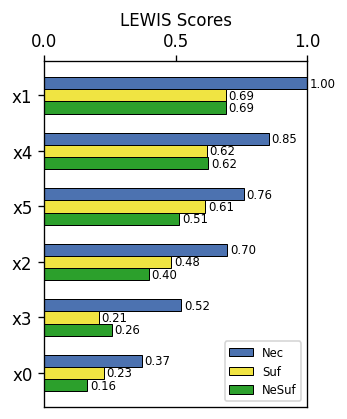

In [9]:
nec = []
suf = []
nesuf = []
for name in feature_names:
    score = score_dic[name]
    nec.append(score[0])
    suf.append(score[1])
    nesuf.append(score[2])
score_df = pd.DataFrame()
score_df['feature'] = feature_names
score_df['Nec'] = nec
score_df['Suf'] = suf
score_df['NeSuf'] = nesuf

plot_scores_barh_featurecol(score_df.sort_values(['NeSuf'], ascending=False))